In [1]:
import os
import subprocess
from pathlib import Path

"""
Dynamically find the project root (where .git exists) and set it as the current working directory.
"""
project_root = Path(subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], text=True).strip())
os.chdir(project_root)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import math
import matplotlib.patches as mpatches
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
from matplotlib.lines import Line2D
from matplotlib.patches import Patch



In [ ]:
# Load the U.S. states shapefile
us_states = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")

# Remove Puerto Rico by filtering out 'Puerto Rico' from the 'name' column
us_states = us_states[us_states['name'] != 'Puerto Rico']

# Save the modified shapefile
output_file = 'us_states_no_pr.shp' 
us_states.to_file('data/USData/map/' + output_file)

print(f"Shapefile saved as {output_file}")

Shapefile saved as us_states_no_pr.shp


In [61]:
# Ensure pandas displays full data
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Don't truncate column data

shapefile_path = '../../USData/map/us_states_no_pr.shp' # Replace with the actual path to your .shp file
gdf = gpd.read_file(shapefile_path)

# Inspect the data to find the column for filtering
print(gdf.head())  # View the first few rows and columns

# Filter for Hawaii (replace 'STATE_NAME' with the actual column name for state names in your data)
hawaii_gdf = gdf[gdf['name'] == 'Hawaii']  # Adjust column name if necessary

# Print information about Hawaii
print("Summary of Hawaii's data:")
print(hawaii_gdf.info())

print("\nHawaii's geometries:")
print(hawaii_gdf['geometry'])

print("\nFull data for Hawaii:")
print(hawaii_gdf)

   id        name  density  \
0  01     Alabama   94.650   
1  02      Alaska    1.264   
2  04     Arizona   57.050   
3  05    Arkansas   56.430   
4  06  California  241.700   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

/home/belgie/anaconda3/envs/ada/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/belgie/anaconda3/envs/ada/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/belgie/anaconda3/envs/ada/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

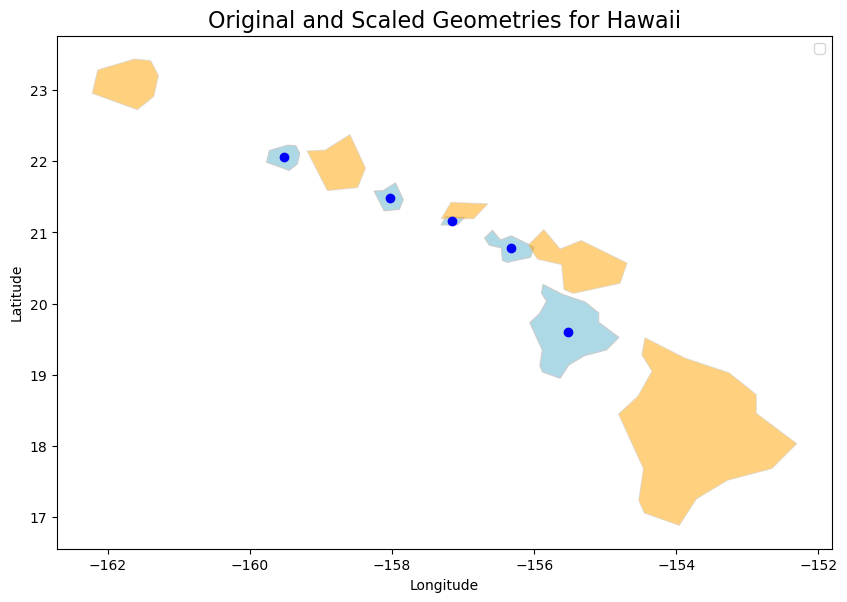

In [66]:
gdf = gpd.read_file('../../USData/map/us_states_no_pr.shp')

state_gdf = gdf[gdf['name'] == 'Hawaii']

# Function to compute centroids for MultiPolygon or Polygon
def compute_centroids(geometry):
    if geometry.geom_type == 'Polygon':
        return geometry.centroid
    elif geometry.geom_type == 'MultiPolygon':
        return [polygon.centroid for polygon in geometry.geoms]

# Apply the function to the 'geometry' column
state_gdf['centroid'] = state_gdf['geometry'].apply(compute_centroids)

# Function to compute a global centroid for all polygons in the geometry
def global_centroid(geometry):
    if geometry.geom_type == 'Polygon':
        return geometry.centroid
    elif geometry.geom_type == 'MultiPolygon':
        # Compute the centroid of the entire MultiPolygon
        multipoint = [polygon.centroid for polygon in geometry.geoms]
        return Point(sum([p.x for p in multipoint]) / len(multipoint), 
                     sum([p.y for p in multipoint]) / len(multipoint))

# Apply the function to compute a global centroid for each geometry
state_gdf['global_centroid'] = state_gdf['geometry'].apply(global_centroid)

# Function to scale distances and shift all points of the polygon by the factor x
def scale_polygon_by_centroid(geometry, centroid, factor):
    if isinstance(geometry, Polygon):
        # Scale each point in the polygon by the vector to the centroid
        new_coords = []
        for x, y in geometry.exterior.coords:
            # Compute vector from centroid to point
            vector_x = x - centroid.x
            vector_y = y - centroid.y
            # Scale the vector by the factor
            new_x = centroid.x + vector_x * factor
            new_y = centroid.y + vector_y * factor
            new_coords.append((new_x, new_y))
        # Return a new scaled Polygon
        return Polygon(new_coords)
    
    elif isinstance(geometry, MultiPolygon):
        # Scale each polygon in the multipolygon
        new_polygons = []
        for polygon in geometry.geoms:
            new_coords = []
            for x, y in polygon.exterior.coords:
                # Compute vector from centroid to point
                vector_x = x - centroid.x
                vector_y = y - centroid.y
                # Scale the vector by the factor
                new_x = centroid.x + vector_x * factor
                new_y = centroid.y + vector_y * factor
                new_coords.append((new_x, new_y))
            # Append the scaled Polygon
            new_polygons.append(Polygon(new_coords))
        # Return a new MultiPolygon
        return MultiPolygon(new_polygons)

# Function to apply scaling to geometries and their centroids
def scale_geometries_by_centroid(row, factor):
    # Use the global centroid for scaling
    return scale_polygon_by_centroid(row['geometry'], row['global_centroid'], factor)

# Apply the scaling function to the geometries
state_gdf['scaled_geometry'] = state_gdf.apply(lambda row: scale_geometries_by_centroid(row, factor=2), axis=1)

# Plot the state geometries and the centroids before and after scaling
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the original geometries (state boundaries)
state_gdf.plot(ax=ax, color='lightblue', linewidth=0.8, edgecolor='0.8', label='State Geometry')

# Plot original centroids (blue dots)
for centroid in state_gdf['centroid']:
    if isinstance(centroid, list):  # MultiPolygon case
        for single_centroid in centroid:
            ax.plot(single_centroid.x, single_centroid.y, 'bo')  # Blue dots for original centroids
    else:
        ax.plot(centroid.x, centroid.y, 'bo')  # Blue dot for original centroid

# Plot scaled geometries (orange polygons)
state_gdf['scaled_geometry'].plot(ax=ax, color='orange', alpha=0.5, linewidth=0.8, edgecolor='0.8', label='Scaled Geometry')

# Add title and labels
plt.title(f'Original and Scaled Geometries for {state_gdf["name"].iloc[0]}', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show legend
plt.legend()

# Show the plot
plt.show()

In [63]:
# Function to compute centroids for MultiPolygon or Polygon
def compute_centroids(geometry):
    if geometry.geom_type == 'Polygon':
        return geometry.centroid
    elif geometry.geom_type == 'MultiPolygon':
        return [polygon.centroid for polygon in geometry.geoms]
    
# Function to compute a global centroid for all polygons in the geometry
def global_centroid(geometry):
    if geometry.geom_type == 'Polygon':
        return geometry.centroid
    elif geometry.geom_type == 'MultiPolygon':
        # Compute the centroid of the entire MultiPolygon
        multipoint = [polygon.centroid for polygon in geometry.geoms]
        return Point(sum([p.x for p in multipoint]) / len(multipoint), 
                     sum([p.y for p in multipoint]) / len(multipoint))
    

# Function to scale distances and shift all points of the polygon by the factor x
def scale_polygon_by_centroid(geometry, centroid, factor):
    if isinstance(geometry, Polygon):
        # Scale each point in the polygon by the vector to the centroid
        new_coords = []
        for x, y in geometry.exterior.coords:
            # Compute vector from centroid to point
            vector_x = x - centroid.x
            vector_y = y - centroid.y
            # Scale the vector by the factor
            new_x = centroid.x + vector_x * factor
            new_y = centroid.y + vector_y * factor
            new_coords.append((new_x, new_y))
        # Return a new scaled Polygon
        return Polygon(new_coords)
    
    elif isinstance(geometry, MultiPolygon):
        # Scale each polygon in the multipolygon
        new_polygons = []
        for polygon in geometry.geoms:
            new_coords = []
            for x, y in polygon.exterior.coords:
                # Compute vector from centroid to point
                vector_x = x - centroid.x
                vector_y = y - centroid.y
                # Scale the vector by the factor
                new_x = centroid.x + vector_x * factor
                new_y = centroid.y + vector_y * factor
                new_coords.append((new_x, new_y))
            # Append the scaled Polygon
            new_polygons.append(Polygon(new_coords))
        # Return a new MultiPolygon
        return MultiPolygon(new_polygons)
    

# Function to apply scaling to geometries and their centroids for a specific state
def scale_geometries_by_centroid(row, factor):
    # Use the global centroid for scaling
    return scale_polygon_by_centroid(row['geometry'], row['global_centroid'], factor)


# Define the function to shift the geometry for a given state
def shift_geometry(geometry, shift_x=None, shift_y=None):
    if isinstance(geometry, Polygon):
        # Shift the coordinates for a single Polygon
        new_coords = []
        for lon, lat in geometry.exterior.coords:
            new_lon = lon + shift_x if shift_x is not None else lon
            new_lat = lat + shift_y if shift_y is not None else lat
            new_coords.append((new_lon, new_lat))
        # Recreate the Polygon with shifted coordinates
        return Polygon(new_coords)
    
    elif isinstance(geometry, MultiPolygon):
        # Shift the coordinates for each Polygon in a MultiPolygon
        new_polygons = []
        for polygon in geometry.geoms:
            new_coords = []
            for lon, lat in polygon.exterior.coords:
                new_lon = lon + shift_x if shift_x is not None else lon
                new_lat = lat + shift_y if shift_y is not None else lat
                new_coords.append((new_lon, new_lat))
            # Append the shifted Polygon
            new_polygons.append(Polygon(new_coords))
        # Recreate the MultiPolygon with shifted polygons
        return MultiPolygon(new_polygons)
    
    else:
        # If the geometry is not a Polygon or MultiPolygon (e.g., a point or line), return as-is
        return geometry
    

# Function taking in a dictionnary of the desired scaling and positioning of desired states
def state_map_modifications(map, modifications):
    # Compute centroids and global centroids for the map
    map['centroid'] = map['geometry'].apply(compute_centroids)
    map['global_centroid'] = map['geometry'].apply(global_centroid)
    
    for state, params in modifications.items():
        # Extract scaling factor and shifts, defaulting to no modification
        scale_factor = params.get('scale', 1)  # Default to no scaling
        shift_x = params.get('shift_x', 0)     # Default to no shift in x
        shift_y = params.get('shift_y', 0)     # Default to no shift in y
        
        # Apply scaling
        if scale_factor != 1:  # Apply scaling only if factor is not 1
            map.loc[map['name'] == state, 'scaled_geometry'] = map.loc[map['name'] == state].apply(
                lambda row: scale_geometries_by_centroid(row, factor=scale_factor), axis=1
            )
        else:
            # If no scaling, use the original geometry for shifting
            map.loc[map['name'] == state, 'scaled_geometry'] = map.loc[map['name'] == state, 'geometry']
        
        # Apply shifting
        map.loc[map['name'] == state, 'shifted_geometry'] = map.loc[map['name'] == state, 'scaled_geometry'].apply(
            lambda geom: shift_geometry(geom, shift_x=shift_x, shift_y=shift_y)
        )
        
        # Update the original geometry with the shifted geometry
        map.loc[map['name'] == state, 'geometry'] = map.loc[map['name'] == state, 'shifted_geometry']
    
    # Drop intermediate columns to keep the GeoDataFrame clean (optional)
    map.drop(columns=['scaled_geometry', 'shifted_geometry'], inplace=True, errors='ignore')
    
    return map

Shapefile saved as us_states_modified.shp


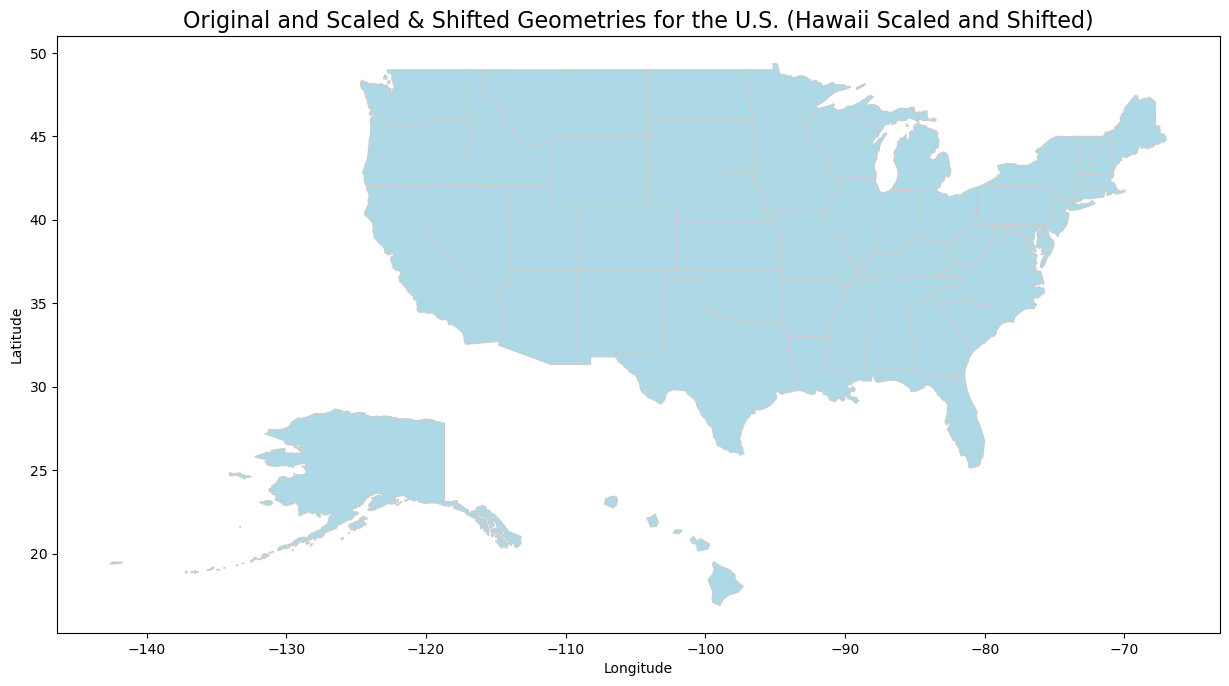

In [ ]:
# Writing the pipeline in the notebook, for the making of the new map, so that we maintain the new positions in a newly saved shp file
# Load the U.S. states shapefile
us_states_map = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")

# Remove Puerto Rico by filtering out 'Puerto Rico' from the 'name' column
us_states_map = us_states_map[us_states_map['name'] != 'Puerto Rico']


map_modifications = {
    'Hawaii': {'scale': 2, 'shift_x': 55},
    'Alaska': {'scale': 0.5, 'shift_x': 30, 'shift_y': -35},
}

us_states_map = state_map_modifications(us_states_map, map_modifications)

us_states_map = us_states_map.drop(columns=['centroid', 'global_centroid'])


# Save the modified shapefile
output_file = 'us_states_modified.shp' 
us_states_map.to_file('data/USData/map/' + output_file)

print(f"Shapefile saved as {output_file}")



fig, ax = plt.subplots(figsize=(15, 15))

# Plot the original geometries (state boundaries)
us_states_map.plot(ax=ax, color='lightblue', linewidth=0.8, edgecolor='0.8')

# Add title and labels
plt.title(f'Original and Scaled & Shifted Geometries for the U.S. (Hawaii Scaled and Shifted)', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')


# Show the plot
plt.show()



Shapefile saved as us_states_modified.shp


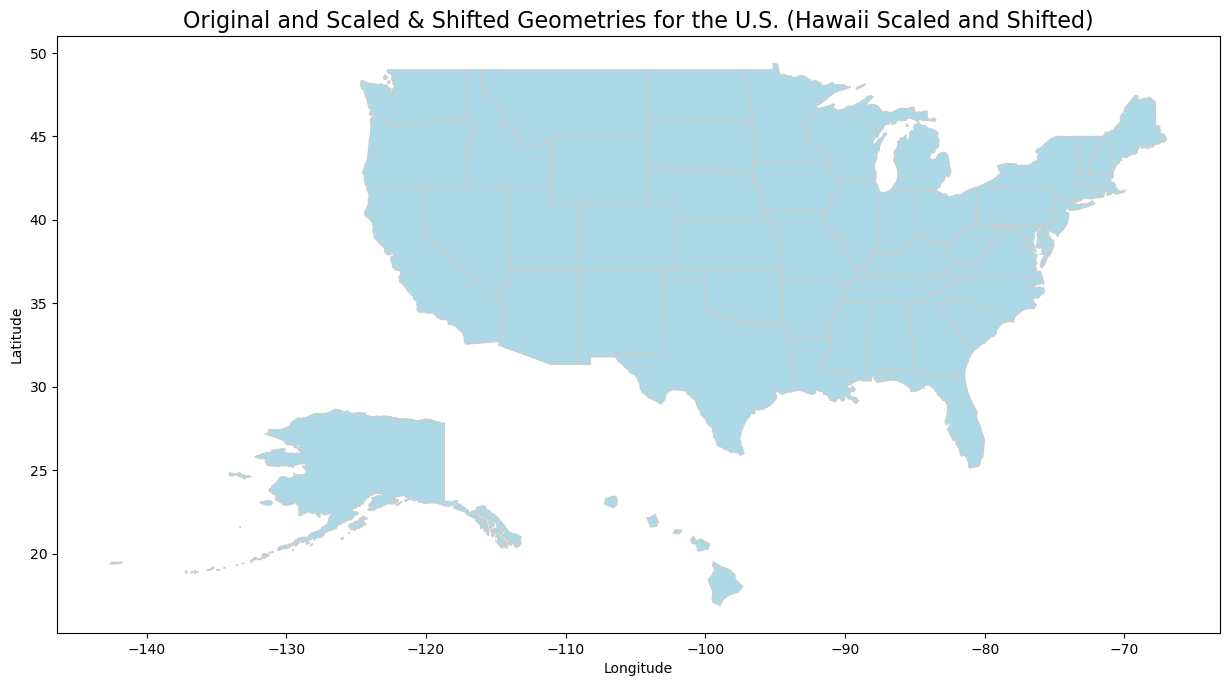

In [ ]:
us_map_path = 'data/USData/map/us_states_modified.shp'
us_states_map = gpd.read_file(us_map_path)

fig, ax = plt.subplots(figsize=(15, 15))

# Plot the original geometries (state boundaries)
us_states_map.plot(ax=ax, color='lightblue', linewidth=0.8, edgecolor='0.8')

# Save the modified shapefile
output_file = 'us_states_modified.shp' 
us_states.to_file('../../USData/map/' + output_file)

print(f"Shapefile saved as {output_file}")

# Add title and labels
plt.title(f'Original and Scaled & Shifted Geometries for the U.S. (Hawaii Scaled and Shifted)', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')


# Show the plot
plt.show()
